<a href="https://colab.research.google.com/github/katyayani-jha/ML-LAB-CS12/blob/main/ML_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
n_samples = 1000
X_base = np.random.rand(n_samples, 1)

# Creating 7 highly correlated features
X = np.hstack([X_base + np.random.normal(0, 0.01, (n_samples, 1)) for _ in range(7)])

# Generating the target variable with some noise
true_coefficients = np.array([5, 4, 3, 2, 1, 0.5, 0.1])
y = X.dot(true_coefficients) + np.random.normal(0, 0.5, n_samples)

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
def ridge_regression_gradient_descent(X, y, learning_rate, reg_param, iterations):
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for i in range(iterations):
        y_pred = X.dot(theta)

        # Computing gradients with L2 regularization
        gradient = (1/m) * X.T.dot(y_pred - y) + (reg_param/m) * theta

        # Updating the weights
        theta -= learning_rate * gradient

        cost = (1/(2*m)) * np.sum((y_pred - y)**2) + (reg_param/(2*m)) * np.sum(theta**2)
        cost_history.append(cost)

        if np.isnan(theta).any() or np.isinf(theta).any():
            print(f"Divergence detected at iteration {i}. Learning rate: {learning_rate}, Regularization: {reg_param}")
            break

    return theta, cost_history

Training with learning rate: 0.0001, regularization parameter: 1e-15
R² score: -2.0646585266774293, Final cost: 32.13736022397866
Training with learning rate: 0.0001, regularization parameter: 1e-10
R² score: -2.0646585266774315, Final cost: 32.13736022397872
Training with learning rate: 0.0001, regularization parameter: 1e-05
R² score: -2.064658526895578, Final cost: 32.137360230011744
Training with learning rate: 0.0001, regularization parameter: 0.001
R² score: -2.0646585484922597, Final cost: 32.13736082728722
Training with learning rate: 0.0001, regularization parameter: 0
R² score: -2.0646585266774293, Final cost: 32.13736022397866
Training with learning rate: 0.0001, regularization parameter: 1
R² score: -2.064680341314116, Final cost: 32.137963497412336
Training with learning rate: 0.0001, regularization parameter: 10
R² score: -2.064876655594619, Final cost: 32.14338979523783
Training with learning rate: 0.0001, regularization parameter: 20
R² score: -2.0650947456810766, Final

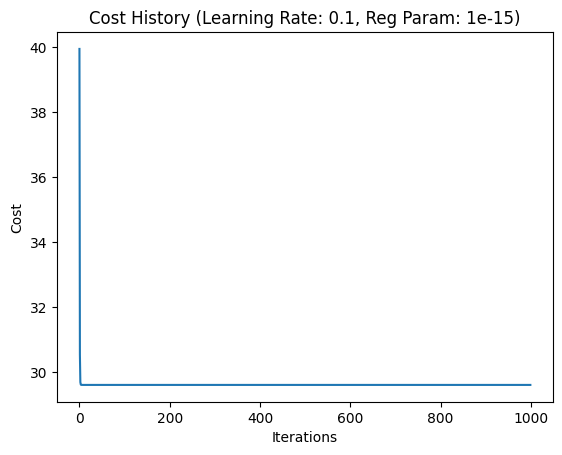

In [13]:
# Hyperparameter tuning
learning_rates = [0.0001, 0.001, 0.01, 0.1]
regularization_params = [10**-15, 10**-10, 10**-5, 10**-3, 0, 1, 10, 20]
iterations = 1000

best_r2_score = -np.inf
best_params = None
best_theta = None
best_cost = None
results = []

for lr in learning_rates:
    for reg_param in regularization_params:
        print(f"Training with learning rate: {lr}, regularization parameter: {reg_param}")

        # Training using gradient descent
        theta, cost_history = ridge_regression_gradient_descent(X_scaled, y, lr, reg_param, iterations)

        y_pred = X_scaled.dot(theta)

        # Handling NaN values in y_pred and y
        mask = ~np.isnan(y_pred) & ~np.isnan(y)  # Filtering out NaN values
        y_pred_filtered = y_pred[mask]
        y_filtered = y[mask]

        if len(y_filtered) > 0:  # Checking if there's data left after filtering
            r2 = r2_score(y_filtered, y_pred_filtered)
        else:
            r2 = np.nan  # Handling the case where all values are NaN

        final_cost = cost_history[-1]

        print(f"R² score: {r2}, Final cost: {final_cost}")

        results.append({
            'learning_rate': lr,
            'reg_param': reg_param,
            'theta': theta,
            'r2_score': r2,
            'cost': final_cost
        })

        if r2 > best_r2_score:
            best_r2_score = r2
            best_params = (lr, reg_param)
            best_theta = theta
            best_cost = final_cost

print(f"\nBest learning rate: {best_params[0]}")
print(f"Best regularization parameter: {best_params[1]}")
print(f"Best R² score: {best_r2_score}")
print(f"Best Ridge Regression cost: {best_cost}")

plt.plot(cost_history)
plt.title(f'Cost History (Learning Rate: {best_params[0]}, Reg Param: {best_params[1]})')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Question 2.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import os

folder_path = '/content/drive/MyDrive'

import pandas as pd

file_path = os.path.join(folder_path, 'Hitters.csv')
df = pd.read_csv(file_path)
print(df.head())

Mounted at /content/drive
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  


In [17]:
numeric_df = df.select_dtypes(include=np.number)

df[numeric_df.columns] = numeric_df.fillna(numeric_df.mean())
df.fillna(df.mode().iloc[0], inplace=True)

# Converting categorical variables to numeric using Label Encoding
label_enc_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in label_enc_cols:
    df[col] = le.fit_transform(df[col])

In [18]:
X = df.drop('Salary', axis=1)  # Assuming 'Salary' is the target variable
y = df['Salary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)

ridge_reg = Ridge(alpha=0.5748)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

lasso_reg = Lasso(alpha=0.5748)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)

In [20]:
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} R² score: {r2}")
    print(f"{model_name} Mean Squared Error (MSE): {mse}\n")
    return r2, mse

evaluate_model(y_test, y_pred_linear, "Linear Regression")

evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

evaluate_model(y_test, y_pred_lasso, "LASSO Regression")

Linear Regression R² score: 0.48395666644591084
Linear Regression Mean Squared Error (MSE): 109801.0001832886

Ridge Regression R² score: 0.48465284254618246
Ridge Regression Mean Squared Error (MSE): 109652.87147559448

LASSO Regression R² score: 0.48541354170746664
LASSO Regression Mean Squared Error (MSE): 109491.01388861175



(0.48541354170746664, 109491.01388861175)

Question 3.

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

In [22]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
boston_df = pd.read_csv(url, delim_whitespace=True, header=None, names=columns)

<ipython-input-22-e854daf9445b>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  boston_df = pd.read_csv(url, delim_whitespace=True, header=None, names=columns)


In [23]:
X = boston_df.drop('MEDV', axis=1)  # Features
y = boston_df['MEDV']  # Target variable (median value of homes)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

alphas = np.logspace(-6, 6, 13)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predicting using the best alpha found by RidgeCV
y_pred_ridge_cv = ridge_cv.predict(X_test)

# LassoCV automatically performs cross-validation and selects the best alpha
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# Predicting using the best alpha found by LassoCV
y_pred_lasso_cv = lasso_cv.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [25]:
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} R² score: {r2}")
    print(f"{model_name} Mean Squared Error (MSE): {mse}\n")
    return r2, mse

evaluate_model(y_test, y_pred_ridge_cv, "RidgeCV")

evaluate_model(y_test, y_pred_lasso_cv, "LassoCV")

print(f"Best alpha for RidgeCV: {ridge_cv.alpha_}")
print(f"Best alpha for LassoCV: {lasso_cv.alpha_}")

RidgeCV R² score: 0.707335330279436
RidgeCV Mean Squared Error (MSE): 21.80735050422663

LassoCV R² score: 0.7112259525060364
LassoCV Mean Squared Error (MSE): 21.517448198437485

Best alpha for RidgeCV: 10.0
Best alpha for LassoCV: 1e-06
